# Assignment 4: Image Super-Resolution

In [1]:
import cv2
import gc
import glob
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torchvision
from torchvision.transforms import ToTensor, ToPILImage
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data
import warnings
from sklearn.metrics import roc_auc_score as auc
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, DataLoader

warnings.filterwarnings('ignore')
%matplotlib inline
img_to_tensor = ToTensor()
tensor_to_pil_img = ToPILImage(mode='RGB')
tensor_to_img = lambda img: cv2.cvtColor(np.array(tensor_to_pil_img(img)), cv2.COLOR_RGB2BGR)

In [ ]:
# For work with google colab.
from google.colab import drive
import nltk
nltk.download('punkt')
drive.mount('/content/drive/')
os.chdir('drive/My Drive/Y-Data/Deep Learning/assignment4/')

## Stage 1

### Create dataset

We would like to create a dataset and a data-loader for the training of super-resolution network.
We will use self-supervision to create our dataset.

* Create a dataset with images of 3 different sizes:
X - 72x72x3 y_mid – 144x144x3 y_large – 288x288x3
You may choose to either persist these different sizes to disk or create them on-the-fly within your data loader


* Split them into training and validating our model, for simplicity, we will use the first 1000 images (~20%) for validation and the rest for training. (note you should have 5011 images in total but are welcome to add more if you wish to)

Note – I strongly recommend to only work on a sample of the data to make the process of loading and processing faster. This is a good practice for quick development of the loading pipeline and initial model creation. Once everything is working the way we expect it to work, we can increase the number of images we load and be sure that the process runs smoothly.

* Next, present few images so that we can compare the training with our desired labels, this process is good for verifying that

In [2]:
# Directory with raw images downloaded.
IMG_DIR = 'small-set/'
# IMG_DIR = 'VOCdevkit/VOC2007/JPEGImages/'
# Directory with images of 3 different sizes: small, medium, large
DATASET_DIR = 'dataset/'

(SMALL_IMG_SIZE) = 72
MEDIUM_IMG_SIZE = 144
LARGE_IMG_SIZE = 288

image_sizes = [SMALL_IMG_SIZE, MEDIUM_IMG_SIZE, LARGE_IMG_SIZE]

test_size = 0.2

path_to_name = lambda f: os.path.splitext(os.path.basename(f))[0]
full_img_list = [path_to_name(img_path) for img_path in glob.glob(IMG_DIR + '*.jpg')]
img_list = full_img_list
len(img_list)

1278

In [3]:
def write_dataset_image(img, img_name, img_size):
  out_img = cv2.resize(img, (img_size, img_size))
  out_path = DATASET_DIR + img_name + '_' + str(img_size) + '.jpg'
  cv2.imwrite(out_path, out_img)

def process_image(img_name):
  img = cv2.imread(IMG_DIR + img_name + '.jpg')
  for img_size in image_sizes:
    write_dataset_image(img, img_name, img_size)

for i in img_list:
    process_image(i)

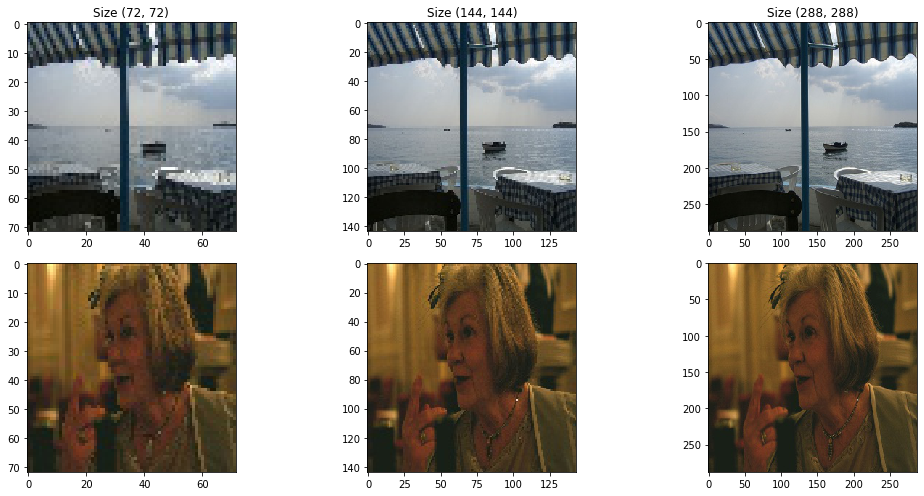

In [4]:
def plot_image(ax, row_idx, img_name):
  for col_idx, img_size in enumerate(image_sizes):
    img = cv2.imread(DATASET_DIR + img_name + '_' + str(img_size) + '.jpg')
    ax[row_idx, col_idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
for row_idx, img_idx in enumerate([1, 8]):
  plot_image(ax, row_idx, img_list[img_idx])
for col, img_size in zip(ax[0], image_sizes):
  col.set_title('Size ({:d}, {:d})'.format(img_size, img_size))
fig.tight_layout()
plt.show()

In [5]:
class DatasetFromList1(Dataset):
  def __init__(self, img_list, img_size):
    super(DatasetFromList1, self).__init__()
    self.source = [DATASET_DIR + img_name + '_' + str(SMALL_IMG_SIZE) + '.jpg' for img_name in img_list]
    self.target = [DATASET_DIR + img_name + '_' + str(img_size) + '.jpg' for img_name in img_list]
 
  def get_img(self, index):
    source = cv2.imread(self.source[index])
    target = cv2.imread(self.target[index])
    return source, target

  def __getitem__(self, index):
    source, target = self.get_img(index)
    return img_to_tensor(source), img_to_tensor(target)

  def __len__(self):
    return len(self.source)

train_set, test_set = train_test_split(img_list, test_size=0.2)

train_med = DatasetFromList1(train_set, MEDIUM_IMG_SIZE)
train_large = DatasetFromList1(train_set, LARGE_IMG_SIZE)

test_med = DatasetFromList1(test_set, MEDIUM_IMG_SIZE)
test_large = DatasetFromList1(test_set, LARGE_IMG_SIZE)

## Stage 2

In [6]:
input_size = SMALL_IMG_SIZE
lr = 10e-3
n_epochs = 3
n_threads = 1
out_channels = 64
stats_step = int(len(img_list) / 100)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### First Model

In [7]:
reshape = lambda x, output_h_w: x.view(-1, output_h_w[0], output_h_w[1], 3)

class Net1(nn.Module):
  def __init__(self, out_channels, output_h_w):
    super(Net1, self).__init__()
    self.input_h_w = (input_size, input_size)
    self.output_h_w = output_h_w
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=out_channels, padding = 1, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, padding = 1, kernel_size=3)
    self.final_conv = nn.Conv2d(in_channels=out_channels, out_channels=3, padding = 1, kernel_size=3)

    self._initialize_weights()

  def forward(self, x):
    x = x.view(-1, 3, self.input_h_w[0], self.input_h_w[1]).float()
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = nn.functional.interpolate(x, self.output_h_w[1])
    x = self.final_conv(x)
    x = F.tanh(x)
    x = torch.add(x, 1.)
    x = torch.mul(x, 0.5)
    return x

  def _initialize_weights(self):
    init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
    init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
    init.orthogonal_(self.final_conv.weight)

In [8]:
def build_first_model(train_dataset, test_dataset, output_h_w, batch_size):
    lr = 10e-4
    out_channels = 64
    
    torch.cuda.empty_cache()

    print('===> Loading datasets')
    training_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    testing_data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    print('===> Building model')
    model1 = Net1(out_channels, output_h_w=output_h_w).to(device)
    criterion = nn.MSELoss()

    optimizer = optim.Adam(model1.parameters(), lr=lr)

    def train(epoch):
        epoch_loss = 0
        model1.train()
        for iteration, batch in enumerate(training_data_loader, 1):
            source, target = batch[0].to(device), batch[1].to(device)
            target = reshape(target, output_h_w).float()

            optimizer.zero_grad()
            pred = model1(source).view(target.shape)
            loss = criterion(pred, target)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

            if iteration % stats_step == 0:
                print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_data_loader), loss.item()))

        print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))

    def test():
        psnr = 0
        model1.eval()
        with torch.no_grad():
            for batch in testing_data_loader:
                source, target = batch[0].to(device), batch[1].to(device)
                target = reshape(target, output_h_w).float()
                prediction = model1(source).view(target.shape)
                loss = criterion(prediction, target).item()
                psnr += 10 * np.log10(1 / loss)
        print("===> Avg. PSNR: {:.4f} dB".format(psnr / len(testing_data_loader)))


    def checkpoint(epoch):
        model_out_path = "model_1_epoch_{}_{}.pth".format(output_h_w[0], epoch)
        torch.save(model1, model_out_path)
        print("Checkpoint saved to {}".format(model_out_path))


    for epoch in range(1, n_epochs + 1):
        train(epoch)
        test()
        checkpoint(epoch)
    
    return model1

model1_med = build_first_model(train_med, test_med, output_h_w=(MEDIUM_IMG_SIZE, MEDIUM_IMG_SIZE), batch_size=24)
model1_large = build_first_model(train_large, test_large, output_h_w=(LARGE_IMG_SIZE, LARGE_IMG_SIZE), batch_size=12)

===> Loading datasets
===> Building model
===> Epoch[1](12/43): Loss: 0.0198
===> Epoch[1](24/43): Loss: 0.0120
===> Epoch[1](36/43): Loss: 0.0116
===> Epoch 1 Complete: Avg. Loss: 0.0225
===> Avg. PSNR: 20.1615 dB
Checkpoint saved to model_1_epoch_144_1.pth
===> Epoch[2](12/43): Loss: 0.0084
===> Epoch[2](24/43): Loss: 0.0096
===> Epoch[2](36/43): Loss: 0.0085
===> Epoch 2 Complete: Avg. Loss: 0.0088
===> Avg. PSNR: 20.6876 dB
Checkpoint saved to model_1_epoch_144_2.pth
===> Epoch[3](12/43): Loss: 0.0094
===> Epoch[3](24/43): Loss: 0.0078
===> Epoch[3](36/43): Loss: 0.0087
===> Epoch 3 Complete: Avg. Loss: 0.0081
===> Avg. PSNR: 20.9439 dB
Checkpoint saved to model_1_epoch_144_3.pth
===> Loading datasets
===> Building model
===> Epoch[1](12/86): Loss: 0.0162
===> Epoch[1](24/86): Loss: 0.0120
===> Epoch[1](36/86): Loss: 0.0093
===> Epoch[1](48/86): Loss: 0.0084
===> Epoch[1](60/86): Loss: 0.0079
===> Epoch[1](72/86): Loss: 0.0105
===> Epoch[1](84/86): Loss: 0.0088
===> Epoch 1 Complet

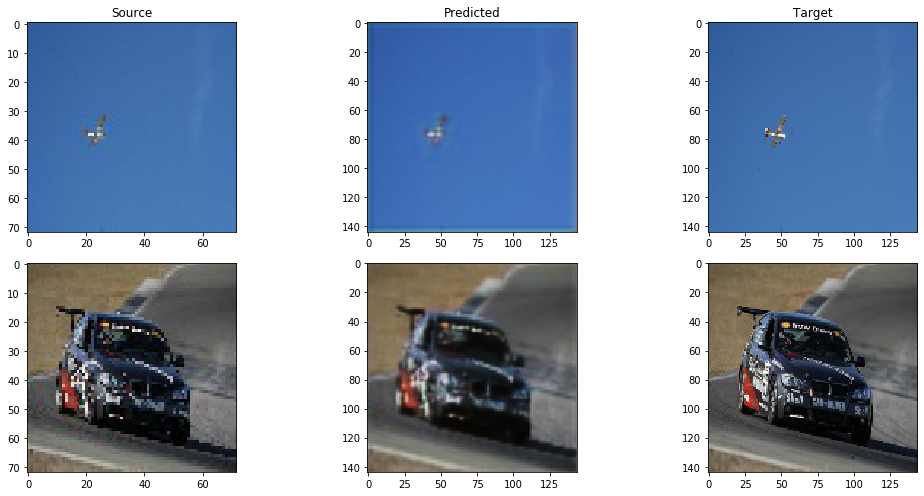

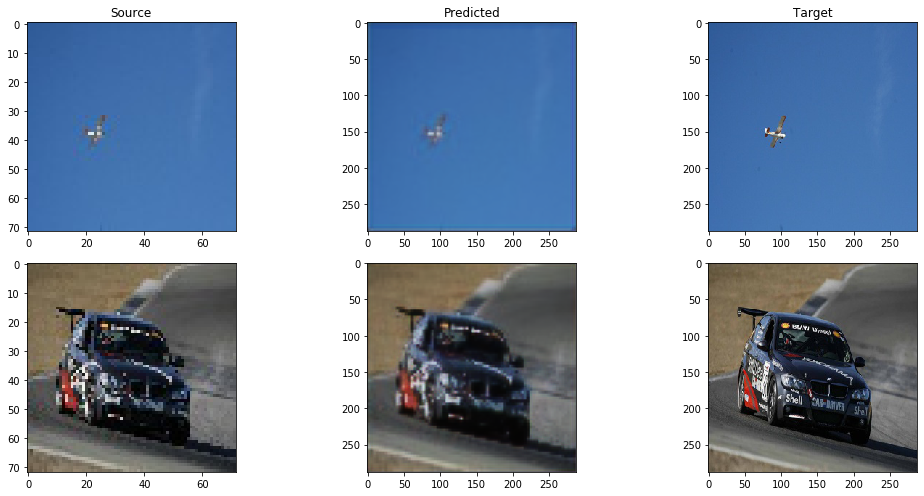

In [9]:
def plot_first_model(model, dataset):
    fig, ax = plt.subplots(2, 3, figsize=(15, 7))
    for row_idx, img_idx in enumerate([1, 5]):
        source, target = dataset[img_idx]
        predicted = model(source.to(device)).cpu().squeeze(0).float().detach()
        ax[row_idx, 0].imshow(tensor_to_img(source))
        ax[row_idx, 1].imshow(tensor_to_img(predicted))
        ax[row_idx, 2].imshow(tensor_to_img(target))
    for col, title in zip(ax[0], ['Source', 'Predicted', 'Target']):
        col.set_title(title)
    fig.tight_layout()
    plt.show()

plot_first_model(model1_med, test_med)
plot_first_model(model1_large, test_large)

## Stage 3

In [10]:
input_size = SMALL_IMG_SIZE
stats_step = int(len(img_list) / 100)
output_sizes = (MEDIUM_IMG_SIZE, LARGE_IMG_SIZE)

### Second Model

In [11]:
class DatasetFromList(Dataset):
  def __init__(self, img_list, img_sizes):
    super(DatasetFromList, self).__init__()
    self.source = [DATASET_DIR + img_name + '_' + str(SMALL_IMG_SIZE) + '.jpg' for img_name in img_list]
    self.targets = [
        [DATASET_DIR + img_name + '_' + str(img_size) + '.jpg' for img_name in img_list]
        for img_size in img_sizes]


  def __getitem__(self, img_idx):
    source = cv2.imread(self.source[img_idx])
    targets = [img_to_tensor(cv2.imread(target[img_idx])) for target in self.targets]
    return img_to_tensor(source), targets

  def __len__(self):
    return len(self.source)

output_image_sizes = (MEDIUM_IMG_SIZE, LARGE_IMG_SIZE)

train_dataset = DatasetFromList(train_set, output_image_sizes)
test_dataset = DatasetFromList(test_set, output_image_sizes)

In [12]:
class Net2(nn.Module):
  def __init__(self, input_size, out_channels, output_sizes):
    super(Net2, self).__init__()
    self.input_size = input_size
    self.output_sizes = output_sizes
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=out_channels, padding = 1, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, padding = 1, kernel_size=3)
    self.final_conv = nn.Conv2d(in_channels=out_channels, out_channels=3, padding = 1, kernel_size=3)

    self._initialize_weights()

  def forward(self, x):
    x = x.view(-1, 3, self.input_size, self.input_size).float()
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    y0 = nn.functional.interpolate(x, self.output_sizes[0])
    y1 = nn.functional.interpolate(y0, self.output_sizes[1])
    return [self._apply_final_conv(y0), self._apply_final_conv(y1)] 

  def _apply_final_conv(self, x):
    x = self.final_conv(x)
    x = F.tanh(x)
    x = torch.add(x, 1.)
    x = torch.mul(x, 0.5)
    return x
    
  def _initialize_weights(self):
    init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
    init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
    init.orthogonal_(self.final_conv.weight)

In [13]:
def build_model(batch_size, lr, n_epochs, out_channels, NetContsrtuctor):
    torch.cuda.empty_cache()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print('===> Loading datasets')
    training_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    testing_data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    print('===> Building model')
    model2 = NetContsrtuctor(input_size, out_channels, output_sizes).to(device)
    criterions = [nn.MSELoss() for i in range(len(output_sizes))]

    optimizer = optim.Adam(model2.parameters(), lr=lr)


    def compute_loss(pred, targets):
        loss = None
        for i, target in enumerate(targets):
            view_shape = (-1, output_sizes[i], output_sizes[i], 3)
            weight = output_sizes[i] ** 2 / np.square(output_sizes).sum()
            curr_loss = criterions[i](pred[i].view(view_shape), target.view(view_shape))
            loss = curr_loss if loss is None else loss + curr_loss
        return loss

    def train(epoch):
        epoch_loss = 0
        model2.train()
        for iteration, batch in enumerate(training_data_loader, 1):
            source, targets = batch[0].to(device), (batch[1][0].to(device), batch[1][1].to(device))

            optimizer.zero_grad()
            loss = compute_loss(model2(source), targets)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

            if iteration % stats_step == 0:
                print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_data_loader), loss.item()))

        print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))

    def test():
        psnr = 0
        model2.eval()
        with torch.no_grad():
            for batch in testing_data_loader:
                source, targets = batch[0].to(device), (batch[1][0].to(device), batch[1][1].to(device))            
                loss = compute_loss(model2(source), targets).item()
                psnr += 10 * np.log10(1 / loss)
        print("===> Avg. PSNR: {:.4f} dB".format(psnr / len(testing_data_loader)))


    def checkpoint(epoch):
        model_out_path = "model2_epoch_{}.pth".format(epoch)
        torch.save(model2, model_out_path)
        print("Checkpoint saved to {}".format(model_out_path))

    for epoch in range(1, n_epochs + 1):
        train(epoch)
        test()
        checkpoint(epoch)
    
    return model2

In [ ]:
model2 = build_model(batch_size=6, lr=10e-3, n_epochs=3, out_channels=32, NetContsrtuctor=Net2)

===> Loading datasets
===> Building model
===> Epoch[1](12/171): Loss: 0.0454
===> Epoch[1](24/171): Loss: 0.0280
===> Epoch[1](36/171): Loss: 0.0305
===> Epoch[1](48/171): Loss: 0.0222
===> Epoch[1](60/171): Loss: 0.0156
===> Epoch[1](72/171): Loss: 0.0200
===> Epoch[1](84/171): Loss: 0.0208
===> Epoch[1](96/171): Loss: 0.0141
===> Epoch[1](108/171): Loss: 0.0153
===> Epoch[1](120/171): Loss: 0.0154
===> Epoch[1](132/171): Loss: 0.0153
===> Epoch[1](144/171): Loss: 0.0103
===> Epoch[1](156/171): Loss: 0.0145
===> Epoch[1](168/171): Loss: 0.0124
===> Epoch 1 Complete: Avg. Loss: 0.0324
===> Avg. PSNR: 18.0328 dB
Checkpoint saved to model2_epoch_1.pth
===> Epoch[2](12/171): Loss: 0.0194
===> Epoch[2](24/171): Loss: 0.0169
===> Epoch[2](36/171): Loss: 0.0137
===> Epoch[2](48/171): Loss: 0.0208
===> Epoch[2](60/171): Loss: 0.0153
===> Epoch[2](72/171): Loss: 0.0133
===> Epoch[2](84/171): Loss: 0.0139
===> Epoch[2](96/171): Loss: 0.0191
===> Epoch[2](108/171): Loss: 0.0161


In [ ]:
def plot_results(model, img_indices):
    fig, ax = plt.subplots(2, 5, figsize=(15, 7))
    for row_idx, img_idx in enumerate(img_indices):
        source, targets = test_dataset[img_idx]
        predicted = model(source.to(device))
        ax[row_idx, 0].imshow(tensor_to_img(source))
        ax[row_idx, 1].imshow(tensor_to_img(predicted[0].cpu().squeeze(0).float().detach()))
        ax[row_idx, 2].imshow(tensor_to_img(predicted[1].cpu().squeeze(0).float().detach()))
        ax[row_idx, 3].imshow(tensor_to_img(targets[0]))
        ax[row_idx, 4].imshow(tensor_to_img(targets[1]))
    for col, title in zip(ax[0], ['Source', 'Predicted Medium', 'Predicted Large', 'Target Medium', 'Target Large']):
        col.set_title(title)
    fig.tight_layout()
    plt.show()

plot_results(model2, img_indices=[1, 8])

## Stage 4

### Third Model

In [ ]:
class Net3(nn.Module):
  def __init__(self, input_size, out_channels, output_sizes):
    super(Net3, self).__init__()
    self.input_size = input_size
    self.output_sizes = output_sizes
    # This layer doesn't appear in the diagram
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=out_channels, padding = 1, kernel_size=3)
    self.res1 = self._create_res_block(out_channels)
    self.res2 = self._create_res_block(out_channels)
    self.res3 = self._create_res_block(out_channels)
    self.final_conv = nn.Conv2d(in_channels=out_channels, out_channels=3, padding = 1, kernel_size=3)

  def forward(self, x):
    x = x.view(-1, 3, self.input_size, self.input_size).float()
    x = self.conv1(x)
    x = F.relu(torch.add(x, self.res1(x)))
    x = F.relu(torch.add(x, self.res2(x)))
    y0 = nn.functional.interpolate(x, self.output_sizes[0])
    y1 = F.relu(torch.add(y0, self.res3(y0)))
    y1 = nn.functional.interpolate(y1, self.output_sizes[1])
    return [self._apply_final_conv(y0), self._apply_final_conv(y1)] 
  
  def _create_res_block(self, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, padding = 1, kernel_size=3),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, padding = 1, kernel_size=3)
    )

  def _apply_final_conv(self, x):
    x = self.final_conv(x)
    x = F.tanh(x)
    x = torch.add(x, 1.)
    x = torch.mul(x, 0.5)
    return x

In [ ]:
model3 = build_model(batch_size=6, lr=10e-4, n_epochs=3, out_channels=32, NetContsrtuctor=Net3)

In [ ]:
plot_results(model3, img_indices=[1, 8])

## Stage 5

### Fourth Model

In [ ]:
class Net4(nn.Module):
  def __init__(self, input_size, out_channels, output_sizes):
    super(Net4, self).__init__()
    self.input_size = input_size
    self.output_sizes = output_sizes
    # This layer doesn't appear in the diagram
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=out_channels, padding = 1, kernel_size=3)
    self.dil1 = self._create_dil_block(out_channels)
    self.dil2 = self._create_dil_block(out_channels)
    self.dil3 = self._create_dil_block(out_channels)
    self.final_conv = nn.Conv2d(in_channels=out_channels, out_channels=3, padding = 1, kernel_size=3)

  def forward(self, x):
    x = x.view(-1, 3, self.input_size, self.input_size).float()
    x = self.conv1(x)
    x = F.relu(self._apply_dil_block(x, self.dil1))
    x = F.relu(self._apply_dil_block(x, self.dil2))
    y0 = nn.functional.interpolate(x, self.output_sizes[0])
    y1 = F.relu(self._apply_dil_block(y0, self.dil3))
    y1 = nn.functional.interpolate(y1, self.output_sizes[1])
    return [self._apply_final_conv(y0), self._apply_final_conv(y1)] 
  
  def _create_dil_block(self, out_channels):
    return (
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, padding=1, kernel_size=3, dilation=1),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, padding=2, kernel_size=3, dilation=2),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, padding=4, kernel_size=3, dilation=4)
    )
  
  def _apply_dil_block(self, x, dil_block):
    return torch.cat([dil(x) for dil in dil_block])

  def _apply_final_conv(self, x):
    x = self.final_conv(x)
    x = F.tanh(x)
    x = torch.add(x, 1.)
    x = torch.mul(x, 0.5)
    return x

In [ ]:
model4 = build_model(batch_size=6, lr=10e-4, n_epochs=3, out_channels=32, NetContsrtuctor=Net4)

In [ ]:
plot_results(model3, img_indices=[1, 8])

## Stage 6

### Fifth Model